In [1]:
# imports
import pandas as pd
import numpy as np
import lightgbm
import sklearn.ensemble
import sklearn.tree
import sklearn
import matplotlib.pyplot
import math
import time

In [2]:
# LECTURA DE ARCHIVOS
bd_path = './'
bd_rul_filename = 'bd_rangos_variablesoperacionales.csv'

In [3]:
dfo = pd.read_csv(bd_path + bd_rul_filename, parse_dates = True)

In [4]:
now = time.time()
acum,tacum,acum_ton = 0.0,0.0,[]
Fallas = dfo["falla"].values[::-1]
TPH = dfo["TpH2_cv05"].values[::-1]
print(Fallas)
print(TPH)
for (falla,tph) in zip(Fallas, TPH):
    if falla > 0.5:
        tacum = 0.0
    elif tph >= 0.0:
        tacum += tph
    acum_ton.append(tacum)
dfo["Ton_acum_futuro"] = acum_ton[::-1]
print(time.time()-now)
dfo["Ton_acum_futuro"].describe()

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
4.249887704849243


count    1.578240e+06
mean     2.199767e+07
std      2.756656e+07
min      0.000000e+00
25%      3.993754e+06
50%      1.275456e+07
75%      2.880414e+07
max      1.965139e+08
Name: Ton_acum_futuro, dtype: float64

In [6]:
dfo.head()
dfo.tail()

Unnamed: 0                 time       ID estado_motor_cv701  \
1578235     1578235  2018-12-31 23:55:00  1578235           DETENIDO   
1578236     1578236  2018-12-31 23:56:00  1578236           DETENIDO   
1578237     1578237  2018-12-31 23:57:00  1578237           DETENIDO   
1578238     1578238  2018-12-31 23:58:00  1578238           DETENIDO   
1578239     1578239  2018-12-31 23:59:00  1578239           DETENIDO   

         velocidad_cv701_rpm  velocidad_cv701  pesometro_cv701  \
1578235                  0.0              0.0              0.0   
1578236                  0.0              0.0              0.0   
1578237                  0.0              0.0              0.0   
1578238                  0.0              0.0              0.0   
1578239                  0.0              0.0              0.0   

         pesometro_cv01  velocidadCero_cv01  velocidadCero_A_cv01  ...  \
1578235       -7.223731            0.408312              0.782206  ...   
1578236       -7.223731            0.399771              0.771006  ...   
1578237       -7.223731            0.391231              0.759806  ...   
1578238       -7.223731            0.382691              0.748605  ...   
1578239       -7.223731            0.374150              0.737405  ...   

         tempPolea7LadoDer_cv07 tiempo fuera de rango  \
1578235                                         200.0   
1578236                                         200.0   
1578237                                         200.0   
1578238                                         200.0   
1578239                                         200.0   

         tempPolea6LadoIzq_cv05 acumulado fuera de rango  \
1578235                                       312.687162   
1578236                                       312.687162   
1578237                                       312.687162   
1578238                                       312.687162   
1578239                                       312.687162   

         tempPolea6LadoIzq_cv05 tiempo fuera de rango  \
1578235                                         217.0   
1578236                                         217.0   
1578237                                         217.0   
1578238                                         217.0   
1578239                                         217.0   

         tempPolea7LadoIzq_cv07 acumulado fuera de rango  \
1578235                                        29.579979   
1578236                                        29.579979   
1578237                                        29.579979   
1578238                                        29.579979   
1578239                                        29.579979   

         tempPolea7LadoIzq_cv07 tiempo fuera de rango  \
1578235                                          21.0   
1578236                                          21.0   
1578237                                          21.0   
1578238                                          21.0   
1578239                                          21.0   

         tempPolea8LadoDer_cv07 acumulado fuera de rango  \
1578235                                       380.240016   
1578236                                       380.240016   
1578237                                       380.240016   
1578238                                       380.240016   
1578239                                       380.240016   

         tempPolea8LadoDer_cv07 tiempo fuera de rango  \
1578235                                         651.0   
1578236                                         651.0   
1578237                                         651.0   
1578238                                         651.0   
1578239                                         651.0   

         tempPolea8LadoIzq_cv07 acumulado fuera de rango  \
1578235                                      2451.206586   
1578236                                      2451.365569   
1578237                                      2451.365569   
1578238                                

In [7]:
var_DEVANADOS = ["tempDevanadoAfd11_1F1_cv05"
    ,"tempDevanadoAfd11_2F1_cv05"
    ,"DtempDevanadoAfd11_1F2_cv05"
    ,"DtempDevanadoAfd11_2F2_cv05"
    ,"DtempDevanadoAfd11_1F3_cv05"
    ,"DtempDevanadoAfd11_2F3_cv05"

    ,"tempDevanadoAfd12_1F1_cv05"
    ,"tempDevanadoAfd12_2F1_cv05"
    ,"DtempDevanadoAfd12_1F2_cv05"
    ,"DtempDevanadoAfd12_2F2_cv05"
    ,"DtempDevanadoAfd12_1F3_cv05"
    ,"DtempDevanadoAfd12_2F3_cv05"

    ,"tempDevanadoAfd21_1F1_cv05"
    ,"tempDevanadoAfd21_2F1_cv05"
    ,"DtempDevanadoAfd21_1F2_cv05"
    ,"DtempDevanadoAfd21_2F2_cv05"
    ,"DtempDevanadoAfd21_1F3_cv05"
    ,"DtempDevanadoAfd21_2F3_cv05"

    ,"tempDevanado_1F1_cv06_Afd12"
    ,"tempDevanado_2F1_cv06_Afd12"
    ,"DtempDevanado_1F2_cv06_Afd12"
    ,"DtempDevanado_2F2_cv06_Afd12"
    ,"DtempDevanado_1F3_cv06_Afd12"
    ,"DtempDevanado_2F3_cv06_Afd12"

    ,"tempDevanado_1F1_cv06_Afd21"
    ,"tempDevanado_2F1_cv06_Afd21"
    ,"DtempDevanado_1F2_cv06_Afd21"
    ,"DtempDevanado_2F2_cv06_Afd21"
    ,"DtempDevanado_1F3_cv06_Afd21"
    ,"DtempDevanado_2F3_cv06_Afd21"

    ,"tempDevanadoAfd11_1F1_cv07"
    ,"tempDevanadoAfd11_2F1_cv07"
    ,"DtempDevanadoAfd11_1F2_cv07"
    ,"DtempDevanadoAfd11_2F2_cv07"
    ,"DtempDevanadoAfd11_1F3_cv07"
    ,"DtempDevanadoAfd11_2F3_cv07"

    ,"tempDevanadoAfd21_1F1_cv07"
    ,"tempDevanadoAfd21_2F1_cv07"
    ,"DtempDevanadoAfd21_1F2_cv07"
    ,"DtempDevanadoAfd21_2F2_cv07"
    ,"DtempDevanadoAfd21_1F3_cv07"
    ,"DtempDevanadoAfd21_2F3_cv07"
           ]
var_AFD = ["TpH2_cv05"
    ,"torqueDriver11_cv05","torqueDriver12_cv05","torqueDriver21_cv05","torqueDriver22_cv05"
    ,"torqueDriverAfd12_cv06","torqueDriver21_cv06","torqueDriverAfd11_cv07","torqueDriver21_cv07"
    ,"potenciaActivaAfd11_cv05","potenciaActivaLinea1Afd12_cv05","potenciaActivaAfd21_cv05"
    ,"potenciaActivaAfd22_cv05","potenciaActivaLinea1Afd12_cv06","potenciaActiva21_cv06"
    ,"potenciaActivaAfd11_cv07","potenciaActiva21_cv07"
    ,"vibracion_DE_11_cv05","vibracion_DE_12_cv05","vibracion_DE_21_cv05","vibracion_DE_22_cv05"
    ,"vibracion_DE_12_cv06","vibracion_DE_21_cv06","vibreacionAfd11_DE_cv07","vibracionAfd21_DE_cv07"
    ,"vibracion_DN_11_cv05","vibracion_DN_12_cv05","vibracion_DN_21_cv05","vibracion_DN_22_cv05"
    ,"vibracion_DN_12_cv06","vibracion_DN_21_cv06","vibracionAfd11_DN_cv07","vibracionAfd21_DN_cv07"
    ,"torque11_cv05","torque12_cv05","torque21_cv05","torque22_cv05","torqueAfd12_cv06","torque21_cv06"
    ,"torque11_cv07","torque21_cv07"
    ,"corrienteMotor11_cv05","corrienteMotor12_cv05","corrienteMotor21_cv05","corrienteMotor22_cv05"
    ,"corrienteMotor12_cv06","corrienteMotor21_cv06","corrienteMotor11_cv07","corrienteMotor21_cv07"
    ,"corrienteLinea1Afd11_cv05","corrienteLinea1Afd12_cv05","corrienteLineaAfd21_cv05","corrienteLineaAfd22_cv05"
    ,"corrienteLinea1Afd12_cv06","corrienteLineaAfd21_cv06","corrienteLineaAfd11_cv07","corrienteLinea21_cv07"
    ,"tempFreno11_cv05","tempFreno12_cv05","tempFreno21_cv05","tempFreno22_cv05","tempFreno12_cV06"
    ,"tempFreno21_cv06","tempFreno22_cv06","tempFreno11_cv07","tempFreno21_cv07"
    ,"tempAceiteTrafoAfd11_cv05","tempAceiteTraffoAfd12_cv05","tempAceiteTrafoAfd21_cv05"
    ,"temperaturaAceiteTraffo_cv06_afd12","temperaturaAceiteTraffo_cv06_Afd21","tempAceiteTrafo11_cv07"
    ,"tempAceiteTrafoAfd21_cv07"
    ,"tempDescansoAfd11_DE_cv05","tempDescansoAfd12_DE_cv05","tempDescansoAfd21_DE_cv05"
    ,"temperaturaDescanso_DE_cv06_Afd12","temperaturaDescanso_DE_cv06_Afd21"
    ,"tempDescansoAfd11_DE_cv07","tempDescansoAfd21_DE_cv07"
    ,"tempDescansoAfd11_ND_cv05","tempDescansoAfd12_DN_cv05","tempDescansoAfd21_ND_cv05"
    ,"temperaturaDescanso_DN_cv06_afd12","temperaturaDescanso_DN_cv06_Afd21"
    ,"tempDescansoAfd11_DN_cv07","tempDescansoAfd21_DN_cv07"
    ,"tempAceiteAfd11_cv05","tempAceiteAfd12_cv05","TempAceite21","tempAceiteAfd12_cv06","red21_temp_aceite_cv06"
    ,"tempAceiteAfd11_cv07","tempAceite21_cv07"
    ,"tempRodamiento1Afd11_cv05","tempRodamiento1Afd12_cv05"
    ,"tempRodamientos1Afd12_cv06","red21_tempRodamientos1_cv06"
    ,"tempRodamiento1Afd11_cv07","tempRodamiento1Afd21_cv07"
    ,"tempRodamiento2Afd11_cv05","tempRodamiento2Afd12_cv05"
    ,"tempRodamientos2Afd12_cv06","red21_tempRodamientos2_cv06"
    ,"tempRodamiento2Afd11_cv07","tempRodamiento2Afd21_cv07"
          ]
var_RESTO = ["alimentacionFeeder_cv05"
    ,"tensionCeldaCargaIzq_cv05","tensionCeldaCargaIzq_cv06","tensionCeldaCargaIzq_cv07"
    ,"tensionCeldaCargaDer_cv05","tensionCeldaCargaDer_cv06","tensionCeldaCargaDer_cv07"
    ,"posicionContraPeso_cv05","posicionContrapeso_cv06"
    ,"potenciaTotalMotor_cv05","potenciaTotal_cv06","potenciaTotalMotor_cv07"
    ,"TpH2_cv05","pesometro_cv01","pesometro_cv701"
    ,"tempFreno31_cv05","tempFreno31_cv06","tempFreno31_cv07"
    ,"tempFreno32_cv05","tempFreno32_cv06"
    ,"presionFreno_cv05","presionFreno_cv06","presionFreno_cv07"
    ,"tempPolea1LadoDer_cv05","temperaturaPolea1LadoDer_cv06","tempPolea1LadoDer_cv07"
    ,"tempPolea1LadoIzq_cv05","temperaturaPolea1LadoIzq_cv06","tempPolea1LadoIzq_cv07"
    ,"tempPolea2LadoDer_cv05","temperaturaPolea2LadoDer_cv06","tempPolea2LadoDer_cv07"
    ,"tempPolea2LadoIzq_cv05","temperaturaPolea2LadoIzq_cv06","tempPolea2LadoIzq_cv07"
    ,"tempPolea3LadoDer_cv05","temperaturaPolea3LadoDer_cv06","tempPolea4LadoDer_cv07"
    ,"tempPolea3LadoIzq_cv05","temperaturaPolea3LadoIzq_cv06","tempPolea4LadoIzq_cv07"
    ,"tempPolea4LadoDer_cv05","temperaturaPolea4LadoDer_cv06","tempPolea5LadoDer_cv07"
    ,"tempPolea4LadoIzq_cv05","temperaturaPolea4LadoIzq_cv06","tempPolea5LadoIzq_cv07"
    ,"tempPolea5LadoDer_cv05","temperaturaPolea5LadoDer_cv06","tempPolea6LadoDer_cv07"
    ,"tempPolea5LadoIzq_cv05","temperaturaPolea5LadoIzq_cv06","tempPolea6LadoIzq_cv07"
    ,"tempPolea6LadoDer_cv05","tempPolea7LadoDer_cv07"
    ,"tempPolea6LadoIzq_cv05","tempPolea7LadoIzq_cv07"
    ,"tempPolea8LadoDer_cv07"
    ,"tempPolea8LadoIzq_cv07"
    ]

In [8]:
var_DEGRADATIONS = [var+" acumulado fuera de rango" for var in var_DEVANADOS+var_AFD+var_RESTO]
var_TDEGRADATIONS = [var+" tiempo fuera de rango" for var in var_DEVANADOS+var_AFD+var_RESTO]

In [9]:
# filtrado de datos para modelo
dfr = dfo[dfo["TpH2_cv05"]>800.0] # que este funcionando con tonelaje

In [22]:
# parameters
seed = 7
off_line = 0.33
test_size = 0.5
Xnames = ['falla anterior minutos']+var_DEVANADOS+var_AFD+var_RESTO#+var_TDEGRADATIONS +var_DEGRADATIONS

#-------------------- variables ----------------------------
#Xnames = [
#'falla anterior minutos'
#,'tempPolea6LadoDer_cv07'
#,'tempAceite21_cv07 acumulado fuera de rango'
#,'tempPolea6LadoIzq_cv07 acumulado fuera de rango'
#,'tempRodamiento1Afd11_cv05 acumulado fuera de rango'
#,'vibracion_DE_22_cv05 acumulado fuera de rango'
#,'DtempDevanado_2F3_cv06_Afd21 acumulado fuera de rango'
#,'vibracion_DN_22_cv05 acumulado fuera de rango'
#,'tempPolea6LadoDer_cv07 acumulado fuera de rango'
#,'DtempDevanadoAfd11_2F2_cv07 acumulado fuera de rango'
#,'temperaturaPolea5LadoDer_cv06'
#,'tempPolea8LadoDer_cv07 acumulado fuera de rango'
#,'temperaturaPolea1LadoDer_cv06 acumulado fuera de rango'
#,'tempDescansoAfd21_DE_cv05 acumulado fuera de rango'
#,'temperaturaPolea3LadoIzq_cv06 acumulado fuera de rango'
#,'temperaturaPolea5LadoIzq_cv06'
#,'temperaturaPolea3LadoDer_cv06'
#,'temperaturaPolea1LadoDer_cv06'
#,'tempPolea6LadoIzq_cv07'
#,'tempPolea7LadoIzq_cv07 acumulado fuera de rango'
#,'tempAceiteAfd11_cv05 acumulado fuera de rango'
#,'tempFreno11_cv05 acumulado fuera de rango'
#,'temperaturaPolea4LadoDer_cv06 acumulado fuera de rango'
#,'tempAceiteTrafoAfd21_cv05 acumulado fuera de rango'
#,'tempAceite21_cv07'
#,'DtempDevanadoAfd21_1F3_cv07 acumulado fuera de rango'
#,'tempPolea8LadoIzq_cv07'
#,'temperaturaPolea4LadoIzq_cv06'
#,'tempDescansoAfd11_DE_cv05'
#,'tempAceiteAfd12_cv05 acumulado fuera de rango'
#,'tempRodamiento1Afd21_cv07'
#,'temperaturaPolea4LadoIzq_cv06 acumulado fuera de rango'
#,'tempPolea4LadoDer_cv05 acumulado fuera de rango'
#,'tempPolea4LadoIzq_cv07 acumulado fuera de rango'
#,'TempAceite21 acumulado fuera de rango'
#,'temperaturaPolea5LadoIzq_cv06 acumulado fuera de rango'
#,'tempDescansoAfd11_DE_cv07 acumulado fuera de rango'
#,'tempPolea5LadoIzq_cv05'
#,'tempPolea6LadoIzq_cv05 acumulado fuera de rango'
#,'tempPolea5LadoDer_cv05 acumulado fuera de rango'
#,'tempPolea2LadoIzq_cv05 acumulado fuera de rango'
#,'temperaturaPolea1LadoIzq_cv06 acumulado fuera de rango'
#,'tempPolea7LadoIzq_cv07'
#,'tempPolea1LadoIzq_cv07'
#,'tempFreno32_cv06'
#,'tempPolea1LadoDer_cv07 acumulado fuera de rango'
#,'tempRodamiento1Afd12_cv05 acumulado fuera de rango'
#,'tempFreno21_cv05 acumulado fuera de rango'
#,'vibreacionAfd11_DE_cv07 acumulado fuera de rango'
#,'DtempDevanadoAfd21_2F2_cv05 acumulado fuera de rango'
#,'temperaturaPolea3LadoIzq_cv06'
#,'tempDescansoAfd21_DE_cv05'
#,'tempFreno31_cv07 acumulado fuera de rango'
#,'tempPolea5LadoDer_cv05'
#,'tempPolea2LadoIzq_cv07'
#,'tempPolea3LadoIzq_cv05 acumulado fuera de rango'
#,'tempPolea1LadoIzq_cv05 acumulado fuera de rango'
#,'tempDescansoAfd21_ND_cv05 acumulado fuera de rango'
#,'tempDescansoAfd11_DE_cv05 acumulado fuera de rango'
#,'tempFreno22_cv05 acumulado fuera de rango'
#,'tempFreno12_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd21_1F2_cv07 acumulado fuera de rango'
#,'DtempDevanado_2F2_cv06_Afd21 acumulado fuera de rango'
#,'tempPolea6LadoIzq_cv05'
#,'tempFreno31_cv07'
#,'tempPolea5LadoIzq_cv05 acumulado fuera de rango'
#,'temperaturaPolea5LadoDer_cv06 acumulado fuera de rango'
#,'tempPolea2LadoIzq_cv07 acumulado fuera de rango'
#,'tempRodamiento2Afd11_cv05 acumulado fuera de rango'
#,'tempAceiteTrafoAfd11_cv05 acumulado fuera de rango'
#,'DtempDevanado_1F3_cv06_Afd21 acumulado fuera de rango'
#,'tempPolea5LadoDer_cv07'
#,'tempPolea8LadoIzq_cv07 acumulado fuera de rango'
#,'tempPolea7LadoDer_cv07 acumulado fuera de rango'
#,'tempPolea6LadoDer_cv05 acumulado fuera de rango'
#,'tempRodamientos2Afd12_cv06 acumulado fuera de rango'
#,'temperaturaDescanso_DE_cv06_Afd21 acumulado fuera de rango'
#,'tempFreno21_cv07 acumulado fuera de rango'
#,'DtempDevanadoAfd12_2F2_cv05 acumulado fuera de rango'
#,'tempPolea7LadoDer_cv07'
#,'presionFreno_cv07'
#,'tempPolea3LadoDer_cv05 acumulado fuera de rango'
#,'presionFreno_cv07 acumulado fuera de rango'
#,'presionFreno_cv05 acumulado fuera de rango'
#,'pesometro_cv701 acumulado fuera de rango'
#,'tempDescansoAfd12_DN_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd11_1F3_cv07 acumulado fuera de rango'
#,'tempDevanadoAfd21_1F1_cv05 acumulado fuera de rango'
#,'tempPolea8LadoDer_cv07'
#,'tempPolea4LadoIzq_cv05 acumulado fuera de rango'
#,'tempPolea5LadoDer_cv07 acumulado fuera de rango'
#,'tempPolea2LadoDer_cv07 acumulado fuera de rango'
#,'tempPolea1LadoDer_cv05 acumulado fuera de rango'
#,'tempRodamiento2Afd12_cv05 acumulado fuera de rango'
#,'tempDescansoAfd11_DN_cv07 acumulado fuera de rango'
#,'vibracion_DE_21_cv06 acumulado fuera de rango'
#,'DtempDevanado_2F3_cv06_Afd12 acumulado fuera de rango'
#,'DtempDevanadoAfd11_2F3_cv05 acumulado fuera de rango'
#,'tempPolea4LadoIzq_cv05'
#,'tempPolea3LadoDer_cv05'
#,'tempPolea4LadoDer_cv07 acumulado fuera de rango'
#,'tempFreno32_cv06 acumulado fuera de rango'
#,'tempDescansoAfd12_DE_cv05 acumulado fuera de rango'
#,'tempFreno12_cV06 acumulado fuera de rango'
#,'vibracion_DN_21_cv06 acumulado fuera de rango'
#,'vibracion_DE_21_cv05 acumulado fuera de rango'
#,'tempPolea3LadoIzq_cv05'
#,'tempPolea2LadoIzq_cv05'
#,'tempPolea1LadoDer_cv07'
#,'temperaturaDescanso_DE_cv06_Afd21'
#,'tempFreno31_cv05 acumulado fuera de rango'
#,'tempRodamiento2Afd21_cv07 acumulado fuera de rango'
#,'tempRodamiento2Afd11_cv07 acumulado fuera de rango'
#,'tempDescansoAfd11_ND_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd12_2F3_cv05 acumulado fuera de rango'
#,'tempDevanadoAfd11_1F1_cv05 acumulado fuera de rango'
#,'tempAceiteAfd11_cv05'
#,'temperaturaDescanso_DN_cv06_Afd21'
#,'temperaturaPolea3LadoDer_cv06 acumulado fuera de rango'
#,'tempPolea2LadoDer_cv05 acumulado fuera de rango'
#,'tensionCeldaCargaIzq_cv07 acumulado fuera de rango'
#,'tensionCeldaCargaIzq_cv05 acumulado fuera de rango'
#,'tempAceiteAfd11_cv07 acumulado fuera de rango'
#,'tempDescansoAfd21_DN_cv07 acumulado fuera de rango'
#,'DtempDevanado_1F3_cv06_Afd12 acumulado fuera de rango'
#,'tempPolea4LadoDer_cv07'
#,'temperaturaPolea2LadoIzq_cv06'
#,'temperaturaPolea1LadoIzq_cv06'
#,'tempRodamiento1Afd11_cv07'
#,'tempDescansoAfd21_ND_cv05'
#,'tempDescansoAfd11_DE_cv07'
#,'temperaturaDescanso_DE_cv06_Afd12'
#,'tempAceiteTrafoAfd21_cv05'
#,'temperaturaPolea2LadoDer_cv06 acumulado fuera de rango'
#,'tempFreno32_cv05 acumulado fuera de rango'
#,'pesometro_cv01 acumulado fuera de rango'
#,'alimentacionFeeder_cv05 acumulado fuera de rango'
#,'tempRodamiento1Afd21_cv07 acumulado fuera de rango'
#,'tempDevanadoAfd11_1F1_cv07 acumulado fuera de rango'
#,'tempDevanadoAfd21_2F1_cv05 acumulado fuera de rango'
#,'tempPolea6LadoDer_cv05'
#,'temperaturaPolea4LadoDer_cv06'
#,'tempPolea4LadoIzq_cv07'
#,'temperaturaPolea2LadoDer_cv06'
#,'tempFreno31_cv06'
#,'tempRodamiento1Afd11_cv05'
#,'tempAceiteTrafoAfd11_cv05'
#,'posicionContrapeso_cv06 acumulado fuera de rango'
#,'tensionCeldaCargaDer_cv07 acumulado fuera de rango'
#,'tempRodamiento1Afd11_cv07 acumulado fuera de rango'
#,'red21_tempRodamientos1_cv06 acumulado fuera de rango'
#,'DtempDevanado_1F2_cv06_Afd21 acumulado fuera de rango'
#,'DtempDevanado_1F2_cv06_Afd12 acumulado fuera de rango'
#,'DtempDevanadoAfd21_1F3_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd12_1F3_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd11_1F3_cv05 acumulado fuera de rango'
#,'tempPolea5LadoIzq_cv07'
#,'tempPolea2LadoDer_cv07'
#,'tempPolea2LadoDer_cv05'
#,'presionFreno_cv05'
#,'tempFreno32_cv05'
#,'tempRodamiento2Afd21_cv07'
#,'tempDescansoAfd21_DN_cv07'
#,'temperaturaDescanso_DN_cv06_afd12'
#,'tempDescansoAfd11_ND_cv05'
#,'tempFreno11_cv05'
#,'tensionCeldaCargaDer_cv05 acumulado fuera de rango'
#,'tensionCeldaCargaIzq_cv06 acumulado fuera de rango'
#,'tempRodamientos1Afd12_cv06 acumulado fuera de rango'
#,'temperaturaDescanso_DE_cv06_Afd12 acumulado fuera de rango'
#,'tempFreno11_cv07 acumulado fuera de rango'
#,'DtempDevanadoAfd21_2F3_cv07 acumulado fuera de rango'
#,'DtempDevanado_2F2_cv06_Afd12 acumulado fuera de rango'
#,'DtempDevanadoAfd11_1F2_cv05 acumulado fuera de rango'
#,'tempPolea4LadoDer_cv05'
#,'tempPolea1LadoDer_cv05'
#,'tempFreno31_cv05'
#,'tempAceiteAfd11_cv07'
#,'tempDescansoAfd11_DN_cv07'
#,'tempDescansoAfd12_DE_cv05'
#,'vibracion_DN_22_cv05'
#,'vibracion_DE_22_cv05'
#,'DtempDevanado_1F3_cv06_Afd12'
#,'tempFreno31_cv06 acumulado fuera de rango'
#,'temperaturaDescanso_DN_cv06_Afd21 acumulado fuera de rango'
#,'tempDescansoAfd21_DE_cv07 acumulado fuera de rango'
#,'torque21_cv05 acumulado fuera de rango'
#,'torqueDriver11_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd11_2F3_cv07 acumulado fuera de rango'
#,'tempDevanadoAfd11_2F1_cv07 acumulado fuera de rango'
#,'tempDevanado_2F1_cv06_Afd12 acumulado fuera de rango'
#,'tempPolea1LadoIzq_cv05'
#,'tempRodamiento2Afd12_cv05'
#,'tempFreno21_cv07'
#,'tempFreno22_cv06'
#,'vibreacionAfd11_DE_cv07'
#,'DtempDevanadoAfd21_1F3_cv05'
#,'tempPolea5LadoIzq_cv07 acumulado fuera de rango'
#,'temperaturaPolea2LadoIzq_cv06 acumulado fuera de rango'
#,'tensionCeldaCargaDer_cv06 acumulado fuera de rango'
#,'temperaturaDescanso_DN_cv06_afd12 acumulado fuera de rango'
#,'corrienteLinea1Afd11_cv05 acumulado fuera de rango'
#,'vibracionAfd11_DN_cv07 acumulado fuera de rango'
#,'torqueDriverAfd12_cv06 acumulado fuera de rango'
#,'TpH2_cv05 acumulado fuera de rango'
#,'tempDevanadoAfd21_1F1_cv07 acumulado fuera de rango'
#,'DtempDevanadoAfd11_1F2_cv07 acumulado fuera de rango'
#,'tempDevanado_1F1_cv06_Afd21 acumulado fuera de rango'
#,'DtempDevanadoAfd21_1F2_cv05 acumulado fuera de rango'
#,'tempRodamiento2Afd11_cv07'
#,'tempRodamiento1Afd12_cv05'
#,'tempFreno11_cv07'
#,'tempFreno12_cV06'
#,'tempFreno12_cv05'
#,'potenciaActiva21_cv06'
#,'potenciaTotalMotor_cv05 acumulado fuera de rango'
#,'red21_temp_aceite_cv06 acumulado fuera de rango'
#,'corrienteLineaAfd21_cv06 acumulado fuera de rango'
#,'torque11_cv05 acumulado fuera de rango'
#,'torqueDriverAfd11_cv07 acumulado fuera de rango'
#,'torqueDriver21_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd21_2F2_cv07 acumulado fuera de rango'
#,'tempDevanadoAfd21_2F1_cv07 acumulado fuera de rango'
#,'tempDevanado_2F1_cv06_Afd21 acumulado fuera de rango'
#,'tempDevanado_1F1_cv06_Afd12 acumulado fuera de rango'
#,'DtempDevanadoAfd12_1F2_cv05 acumulado fuera de rango'
#,'tempDevanadoAfd12_1F1_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd11_2F2_cv05 acumulado fuera de rango'
#,'tempDevanadoAfd11_2F1_cv05 acumulado fuera de rango'
#,'presionFreno_cv06'
#,'tempRodamientos2Afd12_cv06'
#,'tempRodamiento2Afd11_cv05'
#,'red21_tempRodamientos1_cv06'
#,'red21_temp_aceite_cv06'
#,'tempAceiteAfd12_cv06'
#,'tempDescansoAfd21_DE_cv07'
#,'tempFreno22_cv05'
#,'tempFreno21_cv05'
#,'torque11_cv05'
#,'vibracion_DN_21_cv06'
#,'vibracion_DE_21_cv06'
#,'potenciaActiva21_cv07'
#,'torqueDriverAfd11_cv07'
#,'DtempDevanadoAfd21_2F3_cv07'
#,'tempDevanado_1F1_cv06_Afd21'
#,'DtempDevanado_2F2_cv06_Afd12'
#,'DtempDevanadoAfd12_1F3_cv05'
#,'DtempDevanadoAfd11_1F2_cv05'
#,'potenciaTotalMotor_cv07 acumulado fuera de rango'
#,'posicionContraPeso_cv05 acumulado fuera de rango'
#,'red21_tempRodamientos2_cv06 acumulado fuera de rango'
#,'tempAceiteAfd12_cv06 acumulado fuera de rango'
#,'corrienteLinea21_cv07 acumulado fuera de rango'
#,'corrienteMotor22_cv05 acumulado fuera de rango'
#,'torqueAfd12_cv06 acumulado fuera de rango'
#,'vibracion_DN_11_cv05 acumulado fuera de rango'
#,'potenciaActivaAfd11_cv07 acumulado fuera de rango'
#,'torqueDriver21_cv07 acumulado fuera de rango'
#,'tempDevanadoAfd12_2F1_cv05 acumulado fuera de rango'
#,'posicionContrapeso_cv06'
#,'tensionCeldaCargaIzq_cv07'
#,'tensionCeldaCargaIzq_cv05'
#,'red21_tempRodamientos2_cv06'
#,'TempAceite21'
#,'tempAceiteAfd12_cv05'
#,'tempDescansoAfd12_DN_cv05'
#,'corrienteLineaAfd21_cv06'
#,'torque21_cv05'
#,'vibracionAfd11_DN_cv07'
#,'torqueDriverAfd12_cv06'
#,'torqueDriver11_cv05'
#,'TpH2_cv05'
#,'DtempDevanadoAfd21_1F3_cv07'
#,'tempDevanadoAfd21_1F1_cv07'
#,'DtempDevanadoAfd11_2F2_cv07'
#,'tempDevanado_2F1_cv06_Afd21'
#,'DtempDevanado_1F2_cv06_Afd12'
#,'tempDevanado_1F1_cv06_Afd12'
#,'DtempDevanadoAfd21_2F3_cv05'
#,'DtempDevanadoAfd11_2F2_cv05'
#,'tempPolea1LadoIzq_cv07 acumulado fuera de rango'
#,'presionFreno_cv06 acumulado fuera de rango'
#,'tempFreno22_cv06 acumulado fuera de rango'
#,'corrienteLineaAfd21_cv05 acumulado fuera de rango'
#,'corrienteMotor11_cv07 acumulado fuera de rango'
#,'corrienteMotor21_cv06 acumulado fuera de rango'
#,'corrienteMotor21_cv05 acumulado fuera de rango'
#,'torque21_cv06 acumulado fuera de rango'
#,'vibracion_DE_11_cv05 acumulado fuera de rango'
#,'potenciaActiva21_cv06 acumulado fuera de rango'
#,'potenciaActivaAfd22_cv05 acumulado fuera de rango'
#,'potenciaActivaAfd21_cv05 acumulado fuera de rango'
#,'potenciaActivaLinea1Afd12_cv05 acumulado fuera de rango'
#,'potenciaActivaAfd11_cv05 acumulado fuera de rango'
#,'DtempDevanadoAfd21_2F3_cv05 acumulado fuera de rango'
#]

In [23]:
Noff = int(len(dfr.index)*off_line)
X_on,y_on,t_on = dfr[Xnames].values[:-Noff,:],dfr["Ton_acum_futuro"].values[:-Noff],dfr.index[:-Noff]
X_off,y_off,t_off = dfr[Xnames].values[-Noff:,:],dfr["Ton_acum_futuro"].values[-Noff:],dfr.index[-Noff:]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_on,y_on
                                                           ,test_size=test_size, random_state=seed)
model = lightgbm.LGBMRegressor()
#model = xgboost.XGBRegressor(nthreads=4)
#model = sklearn.ensemble.AdaBoostRegressor()
#model = sklearn.ensemble.BaggingRegressor(n_jobs=4)
#model = sklearn.ensemble.RandomForestRegressor(n_jobs=4)
#model = sklearn.ensemble.GradientBoostingRegressor()
#model = sklearn.ensemble.ExtraTreesRegressor(n_jobs=4)
#model = sklearn.tree.DecisionTreeRegressor()
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [24]:
importance = [(i,n) for (i,n) in zip(model.feature_importances_,Xnames)]
importance.sort(key = lambda im: im[0])
importance = importance[::-1]
print('-------------------- variables ----------------------------')
for (i,n) in importance:
    if i>0.000001: print(round(i,3),':',n)

-------------------- variables ----------------------------
260 : falla anterior minutos
124 : tempPolea6LadoDer_cv07
106 : tempPolea7LadoIzq_cv07
91 : temperaturaPolea4LadoIzq_cv06
74 : tempPolea6LadoDer_cv05
70 : temperaturaPolea3LadoDer_cv06
68 : tempDescansoAfd11_DE_cv05
67 : tempPolea4LadoDer_cv07
64 : tempPolea6LadoIzq_cv05
57 : tempPolea5LadoIzq_cv05
57 : temperaturaPolea5LadoDer_cv06
56 : tempPolea6LadoIzq_cv07
50 : tempPolea8LadoDer_cv07
50 : temperaturaPolea3LadoIzq_cv06
49 : tempDescansoAfd21_DE_cv05
48 : tempDescansoAfd11_DE_cv07
47 : tempPolea5LadoDer_cv05
47 : tempAceite21_cv07
46 : tempAceiteTrafoAfd21_cv05
45 : temperaturaPolea1LadoDer_cv06
44 : temperaturaPolea5LadoIzq_cv06
44 : tempPolea2LadoIzq_cv07
43 : tempDescansoAfd21_DE_cv07
42 : tempPolea5LadoDer_cv07
41 : tempFreno32_cv05
40 : tempPolea7LadoDer_cv07
40 : tempPolea1LadoDer_cv05
37 : tempPolea8LadoIzq_cv07
37 : temperaturaPolea4LadoDer_cv06
37 : tempDescansoAfd11_DN_cv07
37 : temperaturaDescanso_DN_cv06_afd12
36

-------------------- train data ----------------------------
median_absolute_error: 4721429.8280994445
mean_absolute_error: 6099751.180412363
max_error: 140207651.51655573
root_mean_squared_error: 8308188.0332977995
explained_variance_score: 0.9269386179281565
r2_score: 0.9269386179281565


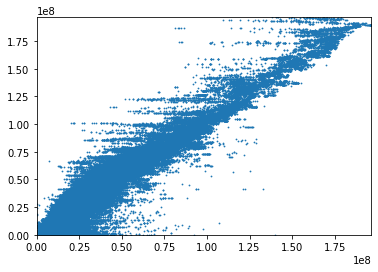

In [25]:
print('-------------------- train data ----------------------------')
y_real,y_pred = y_train,model.predict(X_train)
print('median_absolute_error:',sklearn.metrics.median_absolute_error(y_real, y_pred))
print('mean_absolute_error:',sklearn.metrics.mean_absolute_error(y_real, y_pred))
print('max_error:',sklearn.metrics.max_error(y_real, y_pred))
print('root_mean_squared_error:',math.sqrt(sklearn.metrics.mean_squared_error(y_real, y_pred)))
print('explained_variance_score:',sklearn.metrics.explained_variance_score(y_real, y_pred))
print('r2_score:',sklearn.metrics.r2_score(y_real, y_pred))
matplotlib.pyplot.scatter(y_pred,y_real,s=0.6)
matplotlib.pyplot.ylim(min(y_on),max(y_on))
matplotlib.pyplot.xlim(min(y_on),max(y_on))
matplotlib.pyplot.show()

In [26]:
print('-------------------- test data ----------------------------')
y_real,y_pred = y_test,model.predict(X_test)
print('median_absolute_error:',sklearn.metrics.median_absolute_error(y_real, y_pred))
print('mean_absolute_error:',sklearn.metrics.mean_absolute_error(y_real, y_pred))
print('max_error:',sklearn.metrics.max_error(y_real, y_pred))
print('root_mean_squared_error:',math.sqrt(sklearn.metrics.mean_squared_error(y_real, y_pred)))
print('explained_variance_score:',sklearn.metrics.explained_variance_score(y_real, y_pred))
print('r2_score:',sklearn.metrics.r2_score(y_real, y_pred))
matplotlib.pyplot.scatter(y_pred,y_real,s=0.6)
matplotlib.pyplot.ylim(min(y_on),max(y_on))
matplotlib.pyplot.xlim(min(y_on),max(y_on))
matplotlib.pyplot.show()

-------------------- test data ----------------------------
median_absolute_error: 4746085.017285548
mean_absolute_error: 6161249.456280133
max_error: 143723206.78524554
root_mean_squared_error: 8430076.583955085
explained_variance_score: 0.9244605611449347
r2_score: 0.9244605005910537
